In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision # 데이터 로딩 + 트레이닝 + 테스트 다 같이
import torchvision.transforms as transforms




import warnings
warnings.filterwarnings(action = 'ignore')

# 1.
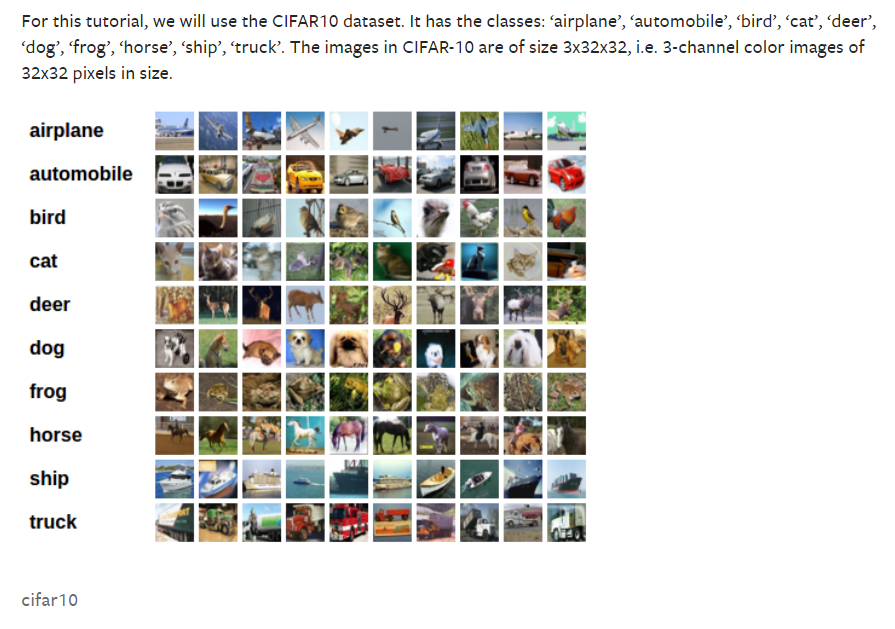

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(2020)
if device =='cuda':
    torch.cuda.manual_seed_all(2020)

Setting up a new session...


Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "C:\Users\drlim\Anaconda3\lib\site-packages\urllib3\connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "C:\Users\drlim\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 80, in create_connection
    raise err
  File "C:\Users\drlim\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\drlim\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "C:\Users\drlim\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "C:\Users\drlim\Anaconda3\lib\http\client.py",

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "C:\Users\drlim\Anaconda3\lib\site-packages\urllib3\connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "C:\Users\drlim\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 80, in create_connection
    raise err
  File "C:\Users\drlim\Anaconda3\lib\site-packages\urllib3\util\connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\drlim\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "C:\Users\drlim\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "C:\Users\drlim\Anaconda3\lib\http\client.py",

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), # to tensor
     
     #The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]. 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
            download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=4) #학습 때는 이미지 자체를 feature에 따라 맞추는 것이 아니라 익숙해진 순서에 따라 맞추는 것 방지 위함이라고 생각된다.                            

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=4)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 10 classes

Files already downloaded and verified
Files already downloaded and verified


In 4~5 : 이미지 보이기 (모델링과 무관)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

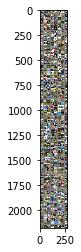

truck  ship  frog horse


In [5]:
dataiter = iter(trainloader) # get some random training images
images, labels = dataiter.next()# random training images



imshow(torchvision.utils.make_grid(images))  # image visualize


print(' '.join('%5s' % classes[labels[j]] for j in range(4)))#label 분류

In [6]:
import torchvision.models.vgg as vgg

cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'] 

In [7]:
class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
vgg19= VGG(vgg.make_layers(cfg),10,True).to(device)    # 10 classes           


In [8]:
a = torch.Tensor(1,3,32,32).to(device)  # batchsize, channel, height, width 순서라고 한다
out = vgg19(a)
print(out)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<AddmmBackward>)


In [9]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(vgg19.parameters(), lr=0.005, momentum=0.9)

lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9) 
# 딥러닝모델 학습 시 lr을 상황에 맞게 변경시키는 방식인 learning rate scheduler 중 하나
# 지정한 스텝 단위 (5)마다 lr에 0.9씩 곱하여 학습률을 감소시킨다고 한다.
print(trainloader)

## epoch 2로 train

In [ ]:
epochs = 2 # EPOCH 2로 트레이닝
for epoch in range(epochs):
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get tue inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        
        optimizer.zero_grad() #0으로 재설정 (누적방지)

  
        outputs = vgg19(inputs) #forward
        loss = criterion(outputs, labels) 
        loss.backward() #bw
        optimizer.step() #optimize

     
        running_loss += loss.item()
        if i % 30 ==29:  # 30번마다 minibatch에서의 loss를 print
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss/30))
            running_loss = 0.0

print('done')

## Test

In [ ]:
dataiter = iter(testloader) #test data에서 random하게
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
#4가지 이미지의 정답지


outputs = vgg19(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4))) 
#4가지 이미지의 예측

# 2. Resnet Cifar10

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform)

print(trainset.data.shape)

train_data_mean = trainset.data.mean( axis=(0,1,2) ) # 3차원 데이터인듯한데 각각 차원에 대한 mean
train_data_std = trainset.data.std( axis=(0,1,2) )# 3차원 데이터인듯한데 각각 차원에 대한 std 계산


print(train_data_mean)
print(train_data_std)

train_data_mean = train_data_mean / 255
train_data_std = train_data_std / 255

print(train_data_mean)
print(train_data_std)

In [ ]:
transform_train = transforms.Compose([    #traindata loading
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(train_data_mean, train_data_std)
])

transform_test = transforms.Compose([   #testdata loading
    transforms.ToTensor(),
    transforms.Normalize(train_data_mean, train_data_std)
])

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
import torchvision.models.resnet as resnet

conv1x1 = resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock = resnet.BasicBlock

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 16, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 32, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 128, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        #x.shape =[1, 16, 32,32]
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.maxpool(x)

        x = self.layer1(x)
        #x.shape =[1, 128, 32,32]
        x = self.layer2(x)
        #x.shape =[1, 256, 32,32]
        x = self.layer3(x)
        #x.shape =[1, 512, 16,16]
        x = self.layer4(x)
        #x.shape =[1, 1024, 8,8]
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
resnet34 = ResNet(resnet.Bottleneck, [3, 4, 6, 3], 10, True).to(device)

a=torch.Tensor(1,3,32,32).to(device)
out = resnet34(a)
print(out)

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(resnet34.parameters(), lr = 0.1, momentum = 0.9, weight_decay=5e-4)
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
epochs = 2

for epoch in range(epochs):

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the unputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet34(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 29: #마찬가지로 30번마다 loss를 print한다
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0

print('done')